In [1]:
import os
import random

import numpy as np
import pandas as pd
import cv2

# import albumentations as A
# from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,cv2,itertools
from glob import glob
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms


In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
data_dir = '/opt/ml/fl_ham/input'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
seed_everything()

In [4]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
categories = dict(zip(df_original['cell_type_idx'], df_original['cell_type']))
print(categories)

{2: 'Benign keratosis-like lesions ', 4: 'Melanocytic nevi', 3: 'Dermatofibroma', 6: 'dermatofibroma', 5: 'Vascular lesions', 1: 'Basal cell carcinoma', 0: 'Actinic keratoses'}


In [5]:
df_original.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /opt/ml/fl_ham/input/HAM10000_images_part_1/IS...   
1  /opt/ml/fl_ham/input/HAM10000_images_part_1/IS...   
2  /opt/ml/fl_ham/input/HAM10000_images_part_1/IS...   
3  /opt/ml/fl_ham/input/HAM10000_images_part_1/IS...   
4  /opt/ml/fl_ham/input/HAM10000_images_part_2/IS...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [7]:
def resnet18_modify(num_classes=7, freeze=False, bn_freeze=True,use_pretrained=True):
    import torchvision.models as models
    model = models.resnet18(pretrained=use_pretrained)

    if freeze:
        print(f'now freezing: {freeze }! bn frezzing: {bn_freeze}')
        freeze_partial(model,bn_freeze)
    num_ftrs = model.fc.in_features # 512

    model.fc = nn.Linear(num_ftrs,num_classes)
    return model

In [8]:
import torch
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import os, cv2,itertools
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
import pickle

In [9]:
class HAM10000_ORG(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        # HAM_0000118	ISIC_0025030	
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        filename = self.df['lesion_id'][index]+self.df['image_id'][index]
        if self.transform:
            X = self.transform(X)

        return X, y,filename


def preprocess_df():
    def get_duplicates(x):
        unique_list = list(df_undup['lesion_id'])
        if x in unique_list:
            return 'unduplicated'
        else:
            return 'duplicated'

    # This set will be df_original excluding all rows that are in the val set
    # This function identifies if an image is part of the train or val set.
    def get_val_rows(x):
        # create a list of all the lesion_id's in the val set
        val_list = list(df_val['image_id'])
        if str(x) in val_list:
            return 'val'
        else:
            return 'train'
    data_dir = '/opt/ml/fl_ham/input'# args.datadir
    all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
    lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'dermatofibroma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }

    df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
    df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
    df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
    df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

    # this will tell us how many images are associated with each lesion_id
    df_undup = df_original.groupby('lesion_id').count()
    # now we filter out lesion_id's that have only one image associated with it
    df_undup = df_undup[df_undup['image_id'] == 1]
    df_undup.reset_index(inplace=True)

    # create a new colum that is a copy of the lesion_id column
    df_original['duplicates'] = df_original['lesion_id']
    # apply the function to this new column
    df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)

    # now we filter out images that don't have duplicates
    df_undup = df_original[df_original['duplicates'] == 'unduplicated']
    print(f'Total non duplicate size:{df_undup.shape}')

    # now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
    y = df_undup['cell_type_idx']
    _, df_val = train_test_split(df_undup, test_size=0.2, random_state=42, stratify=y)
    print(f'From non duplicates, we select validation {df_val.shape}')

    # identify train and val rows
    # create a new colum that is a copy of the image_id column
    df_original['train_or_val'] = df_original['image_id']
    # apply the function to this new column
    df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
    # filter out train rows
    df_train = df_original[df_original['train_or_val'] == 'train']
    print(f'Therefore, total training data: {len(df_train)} & validation data : {len(df_val)}')

    print(f'#### Training distribution ####')
    train_dict = df_train['cell_type_idx'].value_counts().to_dict()
    print(sorted(train_dict.items()))

    print(f'#### Testing distribution ####')
    val_dict = df_val['cell_type_idx'].value_counts().to_dict()
    print(sorted(val_dict.items()))
    df_train = df_train.reset_index()
    df_val = df_val.reset_index()
    return df_train, df_val

In [10]:
batch_size=64
df_train, df_val = preprocess_df()

norm_mean, norm_std = [0.7630318, 0.5456445, 0.5700395], [0.1409281, 0.15261307, 0.16997099]
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                            transforms.ToTensor(),
                                          transforms.Normalize(norm_mean, norm_std)])
val_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),
                                        transforms.Normalize(norm_mean, norm_std)])
training_set = HAM10000_ORG(df_train, transform=train_transform)
validation_set = HAM10000_ORG(df_val, transform=val_transform)
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=4)

Total non duplicate size:(5514, 11)
From non duplicates, we select validation (1103, 11)
Therefore, total training data: 8912 & validation data : 1103
#### Training distribution ####
[(0, 297), (1, 479), (2, 1011), (3, 107), (4, 5822), (5, 129), (6, 1067)]
#### Testing distribution ####
[(0, 30), (1, 35), (2, 88), (3, 8), (4, 883), (5, 13), (6, 46)]


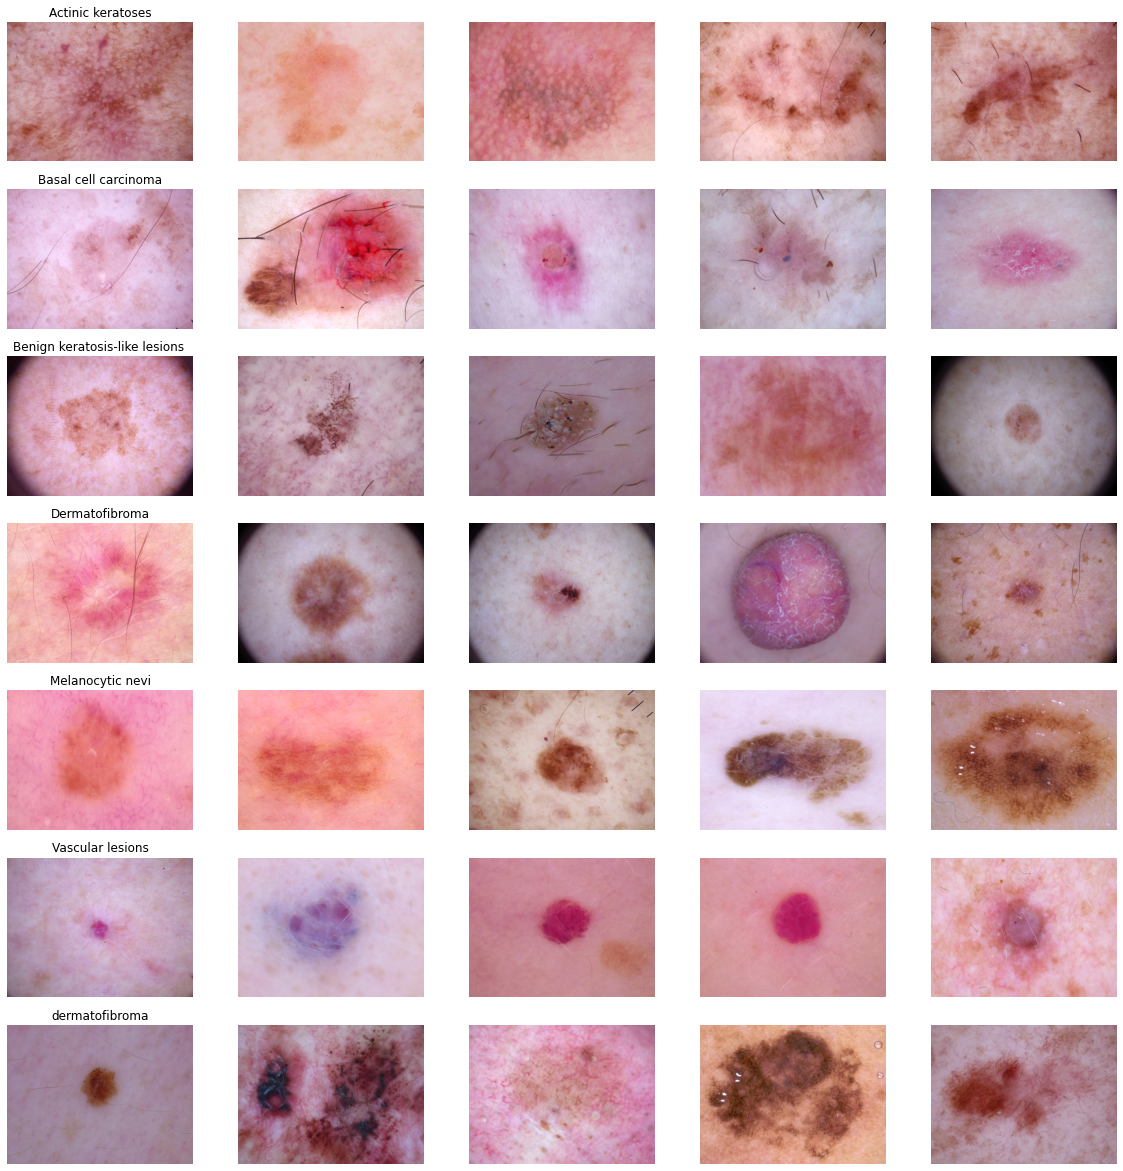

In [11]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df_train.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        img = Image.open(c_row['path'])
        c_ax.imshow(img)
        c_ax.axis('off')

In [12]:
def resnet18_modify(num_classes=7, freeze=False, bn_freeze=True,use_pretrained=True):
    import torchvision.models as models
    model = models.resnet18(pretrained=use_pretrained)

    if freeze:
        print(f'now freezing: {freeze }! bn frezzing: {bn_freeze}')
        freeze_partial(model,bn_freeze)
    num_ftrs = model.fc.in_features # 512

    model.fc = nn.Linear(num_ftrs,num_classes)
    return model

In [13]:
class GradCamModel_ORG(nn.Module):
    """
    for original size model
    """
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        self.pretrained = resnet18_modify()
        # PRETRAINED MODEL
#         if model_type == 'resnet8_gn':
#             self.pretrained = resnet8_gn(num_classes=args.num_classes)
#         elif model_type == 'resnet18':
#             from torchvision import models
#             # input size에 따라서..ㅠㅠ
#             self.pretrained = models.resnet50(pretrained=True)
#             #https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
#             # self.extractor = nn.Sequential(*list(self.pretrained.children())[:-2])
#             self.pretrained = resnet18_modify(num_classes=args.num_classes,
#                                               freeze = args.freeze, bn_freeze = args.bn_freeze,
#                                               use_pretrained=args.pretrained)

        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))

        for p in self.pretrained.parameters():
            p.requires_grad = True

    def activations_hook(self, grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))

        return hook

    def forward(self, x):
        out = self.pretrained(x)
        # for name, module in self.pretrained.submodule

        return out, self.selected_out

In [14]:
from skimage.transform import resize

def denormalize_image(image, mean, std):
    img_cp = image.copy()
    img_cp *= std
    img_cp += mean
    img_cp *= 255.0
    img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
    return img_cp

def do_cam(epoch, model,x, target, preds, selected,batch_idx=10,name='test'):
    selected = selected.detach().cpu()
    grads = model.get_act_grads().detach().cpu()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()
    for i in range(selected.shape[1]):
        selected[:, i, :, :] += pooled_grads[i]
    heatmap_j = torch.mean(selected, dim=1).squeeze()
    heatmap_j_max = heatmap_j.max(axis=0)[0]
    heatmap_j /= heatmap_j_max

    bottle_resized = resize(heatmap_j[batch_idx], (224,224))
    image = x[batch_idx].detach().cpu().permute(1,2,0).numpy()
    new = denormalize_image(image, mean=norm_mean, std=norm_std)
  
    gt = target[batch_idx].detach().cpu().numpy()
    pred = preds[batch_idx].detach().cpu().numpy()
    fig=plt.figure(figsize=(3,3))
    plt.imshow(new)
    plt.imshow(bottle_resized,cmap=plt.cm.jet,alpha=0.2)
    plt.title(f"[@ {epoch}, {name}], GT:{gt} , PRED:{pred}")
    plt.show()
    
def do_cam_multiple(epoch, model,x, target, pred, filename,selected, n_sample=5,name='test'):
    """
    selected = selected.detach().cpu()
    grads = model.get_act_grads().detach().cpu()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()
    for i in range(selected.shape[1]):
        selected[:, i, :, :] += pooled_grads[i]
    heatmap_j = torch.mean(selected, dim=1).squeeze()
    heatmap_j_max = heatmap_j.max(axis=0)[0]
    heatmap_j /= heatmap_j_max

    bottle_resized = resize(heatmap_j, (224,224))
    
    image = x.detach().cpu().permute(0,2,3,1).numpy()
    image = denormalize_image(image, mean=norm_mean, std=norm_std)
  
    gt = target.detach().cpu()
    pred = preds.detach().cpu()
    multiplot(bottle_resized, image, gt, pred, epoch)
    """
    selected = selected.detach().cpu()
    grads = model.get_act_grads().detach().cpu()
    pooled_grads = torch.mean(grads, dim=[2, 3]).detach().cpu()
    for batch_idx in range(selected.shape[0]):
        for ch_idx in range(selected.shape[1]):
            selected[batch_idx, ch_idx, :, :] += pooled_grads[batch_idx][ch_idx]
    heatmap_j = torch.mean(selected, dim=1).squeeze()

    heatmap_j_max = heatmap_j.max(axis=0)[0]
    heatmap_j /= heatmap_j_max

    heatmap = []
    for i in range(heatmap_j.shape[0]):
        vals = resize(heatmap_j[i], (224,224))
        heatmap.append(vals)

    image = x.detach().cpu().permute(0,2,3,1).numpy()
    image = denormalize_image(image, mean=norm_mean, std=norm_std)

    fig, m_axs = plt.subplots(2, n_samples, figsize = (20,10))

    correct_tuple = (pred==target).nonzero(as_tuple=True)[0]
    wrong_tuple = (pred!=target).nonzero(as_tuple=True)[0]
    
    types=['correct','wrong']
    overlay_idx = [
    correct_tuple,
    wrong_tuple
    ]

    for row_idx,(row_axes, show_itr_idx) in enumerate(zip(m_axs, overlay_idx)):
        for col_idx,(col_ax, idx) in enumerate(zip(row_axes,show_itr_idx)):
            col_ax.imshow(image[idx])
            col_ax.imshow(heatmap[idx],cmap=plt.cm.jet,alpha=0.2) #bottle_resized = resize(heatmap_j[batch_idx], (224,224))
            gt_val, pred_val = target[idx].item(), pred[idx].item()
            col_ax.set_title(f"[@ {epoch}, {types[row_idx]}]"+'\n'+
            f"GT:{gt_val}({categories[gt_val]})"+'\n'
             +f"PRED:{pred_val}({categories[pred_val]})" +'\n'
            +f"{filename[idx]}")
            print(filename[idx])
    plt.show()

In [15]:
test_img = [
'HAM_0002574ISIC_0032811',
'HAM_0006328ISIC_0030450',
'HAM_0000306ISIC_0029253',
'HAM_0001817ISIC_0025231',
'HAM_0006432ISIC_0030884',
'HAM_0002952ISIC_0033843',
'HAM_0005124ISIC_0030150',
'HAM_0000791ISIC_0030687',
'HAM_0005992ISIC_0032751',
'HAM_0006171ISIC_0025663',
'HAM_0006518ISIC_0027618',
'HAM_0003560ISIC_0028136',
'HAM_0005288ISIC_0026354',
'HAM_0006496ISIC_0032579',
'HAM_0002915ISIC_0034305',
'HAM_0006692ISIC_0029630',
'HAM_0004878ISIC_0029056',
'HAM_0001991ISIC_0028347',
'HAM_0004371ISIC_0030427',
'HAM_0001443ISIC_0025804'
]

def do_cam_multiple_file(epoch, model,x, target, pred, filename,selected, n_sample=5,name='test'):
    """
    selected = selected.detach().cpu()
    grads = model.get_act_grads().detach().cpu()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()
    for i in range(selected.shape[1]):
        selected[:, i, :, :] += pooled_grads[i]
    heatmap_j = torch.mean(selected, dim=1).squeeze()
    heatmap_j_max = heatmap_j.max(axis=0)[0]
    heatmap_j /= heatmap_j_max

    bottle_resized = resize(heatmap_j, (224,224))
    
    image = x.detach().cpu().permute(0,2,3,1).numpy()
    image = denormalize_image(image, mean=norm_mean, std=norm_std)
  
    gt = target.detach().cpu()
    pred = preds.detach().cpu()
    multiplot(bottle_resized, image, gt, pred, epoch)
    """
    selected = selected.detach().cpu()
    grads = model.get_act_grads().detach().cpu()
    pooled_grads = torch.mean(grads, dim=[2, 3]).detach().cpu()
    for batch_idx in range(selected.shape[0]):
        for ch_idx in range(selected.shape[1]):
            selected[batch_idx, ch_idx, :, :] += pooled_grads[batch_idx][ch_idx]
    heatmap_j = torch.mean(selected, dim=1).squeeze()

    heatmap_j_max = heatmap_j.max(axis=0)[0]
    heatmap_j /= heatmap_j_max

    heatmap = []
    for i in range(heatmap_j.shape[0]):
        vals = resize(heatmap_j[i], (224,224))
        heatmap.append(vals)

    image = x.detach().cpu().permute(0,2,3,1).numpy()
    image = denormalize_image(image, mean=norm_mean, std=norm_std)

    fig, m_axs = plt.subplots(2, n_samples, figsize = (20,10))

    correct_tuple = (pred==target).nonzero(as_tuple=True)[0]
    wrong_tuple = (pred!=target).nonzero(as_tuple=True)[0]

    types=['correct','wrong']
    overlay_idx = [
    correct_tuple,
    wrong_tuple
    ]

    for row_idx,(row_axes, show_itr_idx) in enumerate(zip(m_axs, overlay_idx)):
        for col_idx,(col_ax, idx) in enumerate(zip(row_axes,show_itr_idx)):
            col_ax.imshow(image[idx])
            col_ax.imshow(heatmap[idx],cmap=plt.cm.jet,alpha=0.2) #bottle_resized = resize(heatmap_j[batch_idx], (224,224))
            gt_val, pred_val = target[idx].item(), pred[idx].item()
            col_ax.set_title(f"[@ {epoch}, {types[row_idx]}]"+'\n'+
            f"GT:{gt_val}({categories[gt_val]})"+'\n'
             +f"PRED:{pred_val}({categories[pred_val]})" +'\n'
            +f"{filename[idx]}")
    plt.show()

In [60]:
model = GradCamModel_ORG()
device='cuda'
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4,
                          momentum=0.5,
                          weight_decay=1e-4, nesterov=True)
model.to(device)
criterion = nn.CrossEntropyLoss()

In [26]:
# save img,histo per epoch
num_epochs =20
test_img_dict = {
name:[[] for _ in range(num_epochs)] for name in test_img
}

In [61]:
model = GradCamModel_ORG()
device='cuda'
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4,
                          momentum=0.5,
                          weight_decay=1e-4, nesterov=True)
model.to(device)
criterion = nn.CrossEntropyLoss()

num_epochs =20
test_img_dict = {
name:[[] for _ in range(num_epochs)] for name in test_img
}
# same file shows
# from tqdm.notebook import tqdm
for epoch in range(num_epochs):
    print(f'doing {epoch}')
    batch_cnt = 0
    data_cnt = 0

    loss_val = 0
    acc_val = 0
    
    for idx,(x,target,filename) in enumerate(train_loader):
        if idx %10 ==0:
            print(f'doing {epoch}-{idx}')
        x, target = x.to(device), target.to(device)

        optimizer.zero_grad()
        target = target.long()
        out, selected = model(x) # selected shape: torch.Size([64, 64, 8, 8])
        loss = criterion(out, target)

        _, pred = torch.max(out, 1)
        correct = torch.sum(pred == target)
        loss.backward()
#         if idx ==1:
#             break
        for batch_idx,f in enumerate(filename):
            if f in test_img:
                with torch.no_grad():
                    # do_cam_multiple_file(epoch, model,x, target, pred, filename,selected)
                    # def do_cam(epoch, model,x, target, preds, selected,batch_idx=10,name='test'):
                    selected = selected.detach().cpu()
                    grads = model.get_act_grads().detach().cpu()
                    pooled_grads = torch.mean(grads, dim=[2, 3]).detach().cpu()
                    
                    for ch_idx in range(selected.shape[1]):
                        selected[batch_idx, ch_idx, :, :] += pooled_grads[batch_idx][ch_idx]
                    heatmap_j = torch.mean(selected, dim=1).squeeze()

                    heatmap_j_max = heatmap_j.max(axis=0)[0]
                    heatmap_j /= heatmap_j_max
                    """
                    heatmap = []
                    for i in range(heatmap_j.shape[0]):
                        vals = resize(heatmap_j[i], (224,224))
                        heatmap.append(vals)
                    """
                    bottle_resized = resize(heatmap_j[batch_idx], (224,224))
                    
                    image = x.detach().cpu().permute(0,2,3,1).numpy()
                    image = denormalize_image(image, mean=norm_mean, std=norm_std)
             
                    """
                    selected = selected.detach().cpu()
                    grads = model.get_act_grads().detach().cpu()
                    pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()
                    for i in range(selected.shape[1]):
                        selected[:, i, :, :] += pooled_grads[i]
                    heatmap_j = torch.mean(selected, dim=1).squeeze()
                    heatmap_j_max = heatmap_j.max(axis=0)[0]
                    heatmap_j /= heatmap_j_max

                    bottle_resized = resize(heatmap_j[batch_idx], (224,224))
                    image = x[batch_idx].detach().cpu().permute(1,2,0).numpy()
                    new = denormalize_image(image, mean=norm_mean, std=norm_std)
                    """
                    
                    gt = target[batch_idx].detach().cpu().numpy()
                    pred_this = pred[batch_idx].detach().cpu().numpy()
                    test_img_dict[f][epoch] = [image[batch_idx], bottle_resized, gt, pred_this,out[batch_idx], selected[batch_idx]]
                   
                    
#                     fig=plt.figure(figsize=(3,3))
#                     plt.imshow(new)
#                     plt.imshow(bottle_resized,cmap=plt.cm.jet,alpha=0.2)
#                     plt.title(f"[@ {epoch}, {f}]"+'\n'+ 
#                               f"GT:{gt} , PRED:{pred_this}")
#                     plt.show()

        optimizer.step()
       
        batch_cnt += 1
        data_cnt += target.shape[0]

        loss_val += loss.detach().item()
        acc_val += correct
        
     
    total_acc = acc_val/data_cnt
    total_loss = loss_val/batch_cnt
    print(f'at {epoch} : acc {total_acc} , loss: {total_loss}')
    with open('data.pickle', 'wb') as f:
        pickle.dump(test_img_dict, f)
    print(f'saved done at {epoch}')

doing 0
doing 0-0
doing 0-10
doing 0-20
doing 0-30
doing 0-40
doing 0-50
doing 0-60
doing 0-70
doing 0-80
doing 0-90
doing 0-100
doing 0-110
doing 0-120
doing 0-130
at 0 : acc 0.5201975107192993 , loss: 1.4315018453768322
saved done at 0
doing 1
doing 1-0
doing 1-10
doing 1-20
doing 1-30
doing 1-40
doing 1-50
doing 1-60
doing 1-70
doing 1-80
doing 1-90
doing 1-100
doing 1-110
doing 1-120
doing 1-130
at 1 : acc 0.6551840305328369 , loss: 1.0720572867563793
saved done at 1
doing 2
doing 2-0
doing 2-10
doing 2-20
doing 2-30
doing 2-40
doing 2-50
doing 2-60
doing 2-70
doing 2-80
doing 2-90
doing 2-100
doing 2-110
doing 2-120
doing 2-130
at 2 : acc 0.6577648520469666 , loss: 1.0161277587924684
saved done at 2
doing 3
doing 3-0
doing 3-10
doing 3-20
doing 3-30
doing 3-40
doing 3-50
doing 3-60
doing 3-70
doing 3-80
doing 3-90
doing 3-100
doing 3-110
doing 3-120
doing 3-130
at 3 : acc 0.6642729043960571 , loss: 0.9765919953584671
saved done at 3
doing 4
doing 4-0
doing 4-10
doing 4-20
doing 4-

KeyboardInterrupt: 

In [71]:
with open('data.pickle', 'wb') as f:
    pickle.dump(test_img_dict, f)

KeyboardInterrupt: 

In [72]:
file = open('data.pickle','rb')
data = pickle.load(file)

In [75]:
data['HAM_0002574ISIC_0032811'][14][-1].shape

torch.Size([512, 7, 7])

0


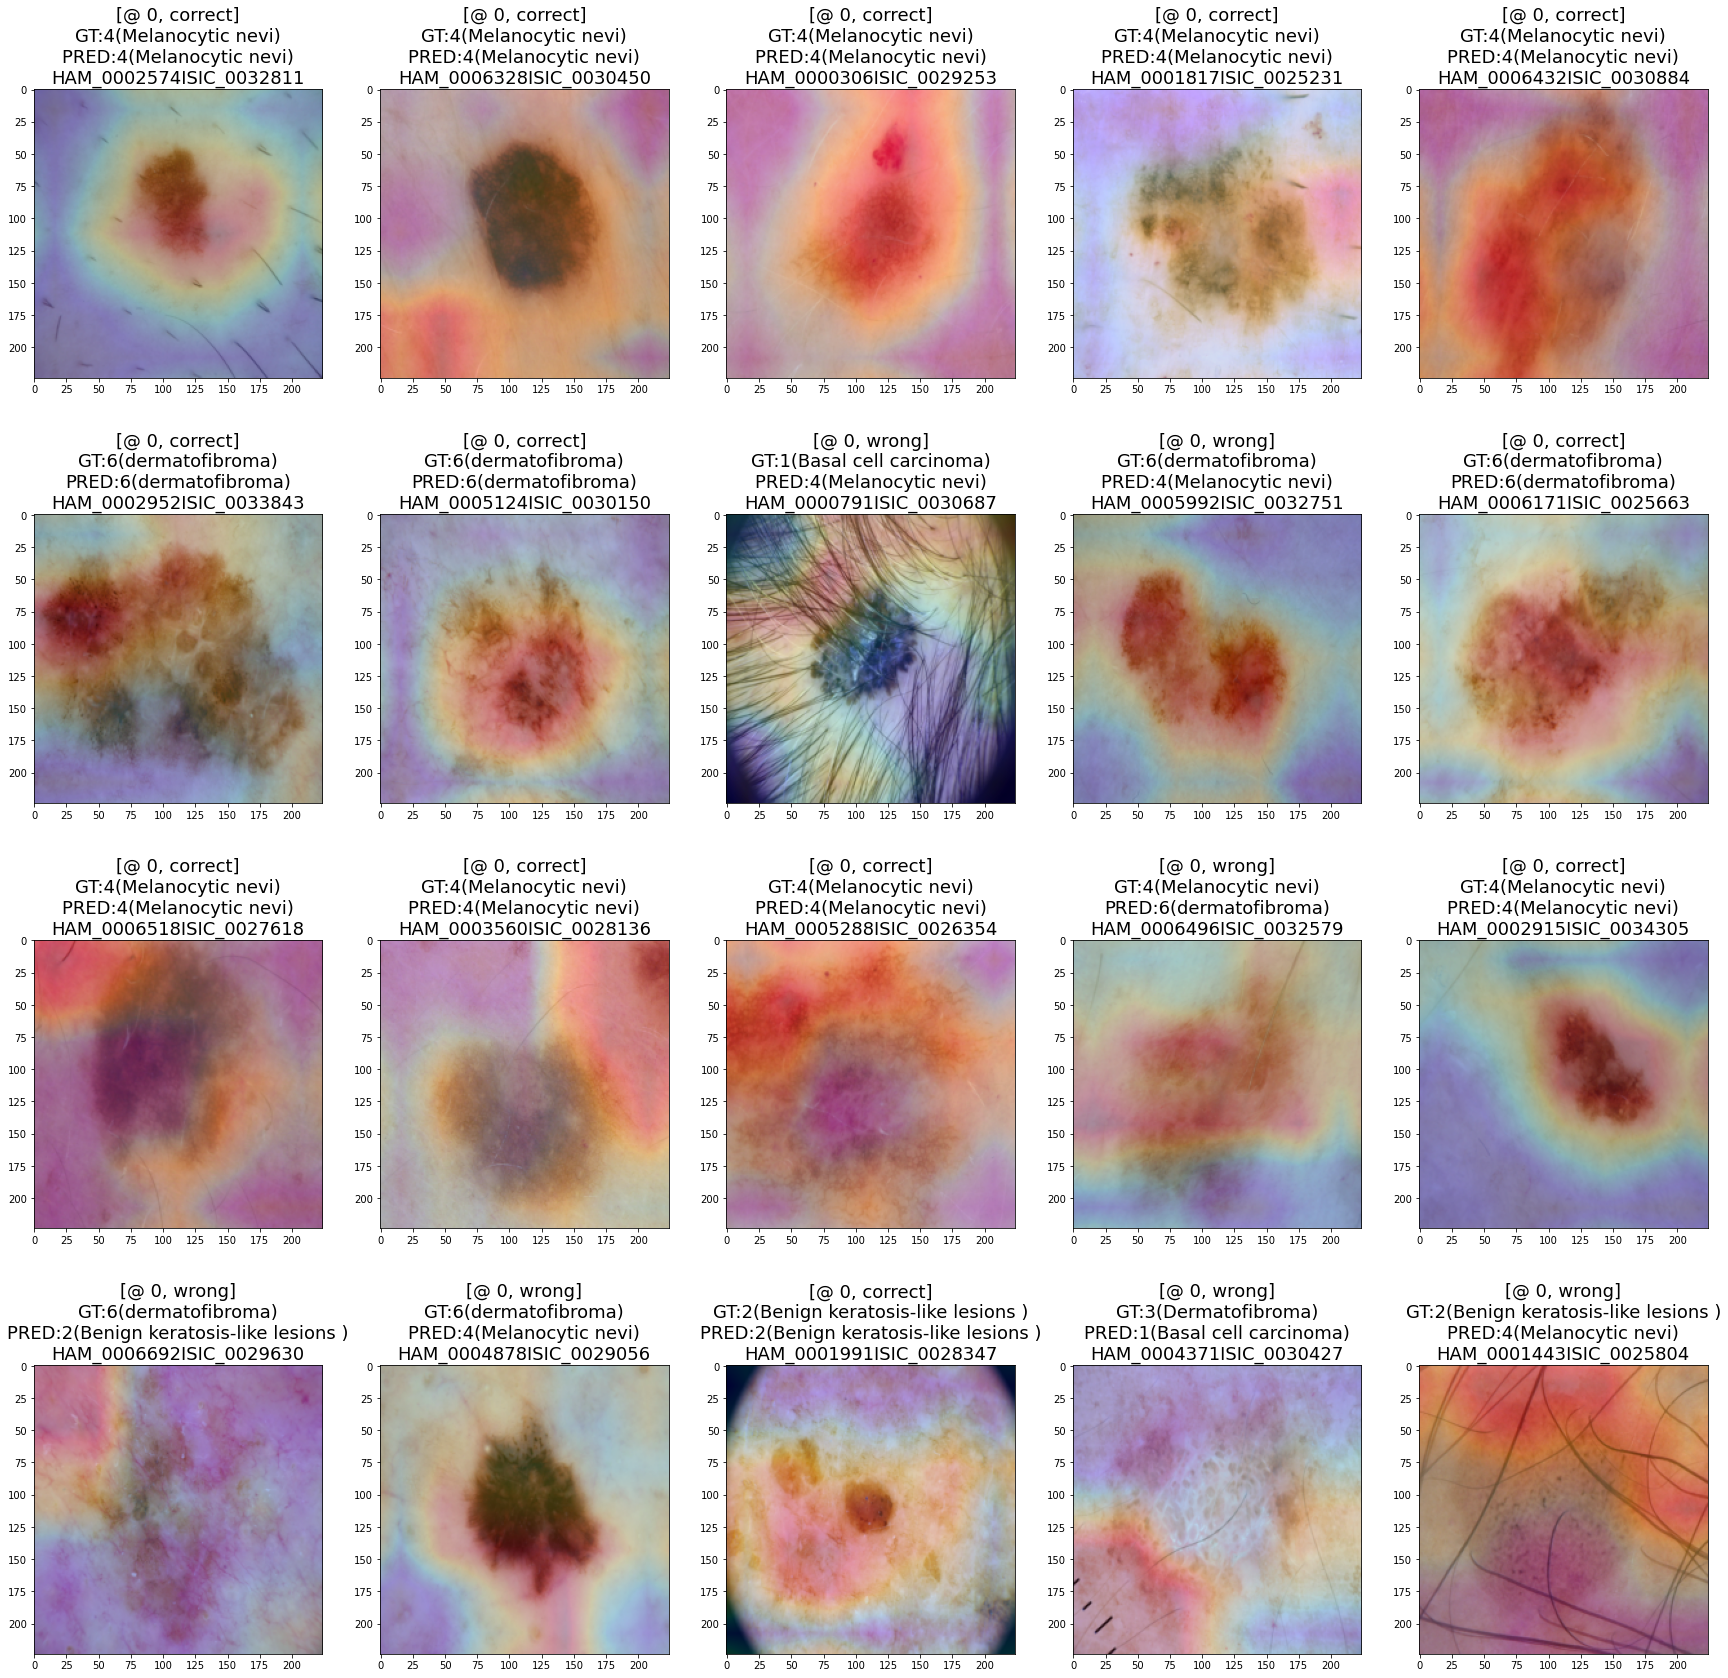

In [38]:
len(test_img_dict) # 20
n_samples = 5

to_list = [k for k in test_img_dict.keys()]
overlay_idx = [to_list[:n_samples],
               to_list[n_samples:2*n_samples], 
               to_list[2*n_samples:3*n_samples],
               to_list[3*n_samples:4*n_samples],
               to_list[4*n_samples:]]

# types=['correct','wrong']
# overlay_idx = [
# correct_tuple,
# wrong_tuple
# ]
num_epoch = 1
for epoch in range(num_epoch):
    print(epoch)
    fig, m_axs = plt.subplots(4, n_samples, figsize = (30,30))
    for row_idx,(row_axes, sample_file_list) in enumerate(zip(m_axs, overlay_idx)):
        for col_idx,(col_ax, sample_name) in enumerate(zip(row_axes,sample_file_list)):
            col_ax.imshow(test_img_dict[sample_name][epoch][0])
            col_ax.imshow(test_img_dict[sample_name][epoch][1],cmap=plt.cm.jet,alpha=0.2) #bottle_resized = resize(heatmap_j[batch_idx], (224,224))
            gt_val, pred_val = int(test_img_dict[sample_name][epoch][2]), int(test_img_dict[sample_name][epoch][3])
            if gt_val == pred_val:
                ans = 'correct'
            else:
                ans = 'wrong'
       
            col_ax.set_title(f"[@ {epoch}, {ans}]"+'\n'+
            f"GT:{gt_val}({categories[gt_val]})"+'\n'
             +f"PRED:{pred_val}({categories[pred_val]})" +'\n'
            +f"{sample_name}", fontsize=18)
    plt.show()

In [79]:
# # correct, wrong showing

# for epoch in range(num_epochs):
#     batch_cnt = 0
#     data_cnt = 0

#     loss_val = 0
#     acc_val = 0
    
#     for idx,(x,target,filename) in enumerate(train_loader):
#         x, target = x.to(device), target.to(device)

#         optimizer.zero_grad()
#         target = target.long()
#         out, selected = model(x) # selected shape: torch.Size([64, 64, 8, 8])
#         loss = criterion(out, target)

#         _, pred = torch.max(out, 1)
#         correct = torch.sum(pred == target)
#         loss.backward()
#         if idx <3:
#             with torch.no_grad():
#                 do_cam_multiple(epoch, model,x, target, pred, filename,selected)

#         optimizer.step()
       
#         batch_cnt += 1
#         data_cnt += target.shape[0]

#         loss_val += loss.detach().item()
#         acc_val += correct
            
            
#     total_acc = acc_val/data_cnt
#     total_loss = loss_val/batch_cnt
#     print(total_acc, total_loss)

In [153]:
for idx,(x,target) in enumerate(train_loader):
    x, target = x.to(device), target.to(device)

    optimizer.zero_grad()
    target = target.long()
    out, selected = model(x) # selected shape: torch.Size([64, 64, 8, 8])
    selected = selected.detach().cpu()
    loss = criterion(out, target)

    _, pred = torch.max(out, 1)
    print(pred==target)
    print((pred==target).nonzero(as_tuple=True))
    print((pred!=target).nonzero(as_tuple=True))
    correct = torch.sum(pred == target)
    loss.backward()
    grads = model.get_act_grads().detach().cpu()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()
    for i in range(selected.shape[1]):
        selected[:, i, :, :] += pooled_grads[i]
    heatmap_j = torch.mean(selected, dim=1).squeeze()
    heatmap_j_max = heatmap_j.max(axis=0)[0]
    heatmap_j /= heatmap_j_max
            
    if idx==1:
        break

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True, False, False, False,  True, False, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True, False, False,  True], device='cuda:0')
(tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 11, 12, 14, 15, 18, 19, 20, 21, 22,
        23, 24, 25, 27, 29, 30, 31, 32, 36, 39, 40, 41, 43, 44, 45, 46, 47, 48,
        50, 51, 52, 53, 54, 55, 58, 59, 60, 63], device='cuda:0'),)
(tensor([ 3, 10, 13, 16, 17, 26, 28, 33, 34, 35, 37, 38, 42, 49, 56, 57, 61, 62],
       device='cuda:0'),)
tensor([False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True, False, False,  True, False,  True,  True, False,

In [27]:
def test():
    selected = selected.detach().cpu()
    grads = model.get_act_grads().detach().cpu()

    pooled_grads = torch.mean(grads, dim=[2, 3]).detach().cpu()

    for batch_idx in range(selected.shape[0]):
        for ch_idx in range(selected.shape[1]):
            selected[batch_idx, ch_idx, :, :] += pooled_grads[batch_idx][ch_idx]
    # for i in range(selected.shape[1]):
    #     selected[:, i, :, :] += pooled_grads[i]

    heatmap_j = torch.mean(selected, dim=1).squeeze()

    heatmap_j_max = heatmap_j.max(axis=0)[0]
    heatmap_j /= heatmap_j_max

    heatmap = []
    for i in range(heatmap_j.shape[0]):
        vals = resize(heatmap_j[i], (224,224))
        heatmap.append(vals)

    image = x.detach().cpu().permute(0,2,3,1).numpy()
    image = denormalize_image(image, mean=norm_mean, std=norm_std)
    # print(image.shape)
    n_samples=5
    fig, m_axs = plt.subplots(2, n_samples, figsize = (20,10))

    correct_tuple = (pred==target).nonzero(as_tuple=True)[0]
    wrong_tuple = (pred!=target).nonzero(as_tuple=True)[0]

    #     correct_tuple = (pred==gt).nonzero(as_tuple=True)[0][:n_samples]
    #     wrong_tuple = (pred!=gt).nonzero(as_tuple=True)[0][:n_samples]
    #     for cor_cnt in correct_tuple[:n_samples]:
    #         do_cam(epoch, model,x, target, pred, selected, batch_idx=cor_cnt,name='correct')
    #     for wor_cnt in wrong_tuple[:n_samples]:
    #         do_cam(epoch, model,x, target, pred, selected, batch_idx=wor_cnt,name='wrong')

    types=['correct','wrong']
    overlay_idx = [
    correct_tuple,
    wrong_tuple
    ]

    for row_idx,(row_axes, show_itr_idx) in enumerate(zip(m_axs, overlay_idx)):
        for col_idx,(col_ax, idx) in enumerate(zip(row_axes,show_itr_idx)):
            col_ax.imshow(image[idx])
            col_ax.imshow(heatmap[idx],cmap=plt.cm.jet,alpha=0.2) #bottle_resized = resize(heatmap_j[batch_idx], (224,224))
            gt_val, pred_val = target[idx].item(), pred[idx].item()
            col_ax.set_title(f"[@ {epoch}, {types[row_idx]}]"+'\n'+
            f"GT:{gt_val}({categories[gt_val]})"+'\n'
             +f"PRED:{pred_val}({categories[pred_val]})")
    plt.show()

In [104]:
heatmap_j.shape

torch.Size([7, 7])

In [76]:
# fig = plt.figure(figsize=(8,8))
# plt.imshow(bottle_resized)
# plt.show()

In [77]:
# fig=plt.figure(figsize=(8,8))
# image = x[0].detach().cpu().permute(1,2,0).numpy()
# new = denormalize_image(image, mean=norm_mean, std=norm_std)
# plt.imshow(new)
# plt.show()

In [78]:
# fig=plt.figure(figsize=(8,8))
# plt.imshow(new)
# plt.imshow(bottle_resized,cmap=plt.cm.jet,alpha=0.2)
# plt.title('tt')